## LOBSTER-ECOL GLORYs Surface and Bottom Temperature Processing

Processing zonal timeseries of surface and bottom temperatures from the GLORYs ocean reanalysis product.

In [1]:

####  Libraries  ####
import xarray as xr
import os
import numpy as np
import geopandas as gpd

# Paths to resources
box_path = "/Users/adamkemberling/Library/CloudStorage/Box-Box/"
lobecol_path = f"{box_path}Mills Lab/Projects/Lobster ECOL/Spatial_Defs/"
glorys_path = f"{box_path}RES_Data/GLORYs/NE_Shelf_TempSal/"
fpaths_glorys = os.listdir(glorys_path)

In [2]:
# Open one file to get depth indices
glorys_single = xr.open_mfdataset(f"{glorys_path}{fpaths_glorys[0]}", combine = "by_coords", parallel = True)
glorys_single

<xarray.Dataset> Size: 562MB
Dimensions:    (depth: 38, latitude: 132, longitude: 226, time: 31)
Coordinates:
  * depth      (depth) float32 152B 0.494 1.541 2.646 ... 1.245e+03 1.452e+03
  * latitude   (latitude) float32 528B 35.25 35.33 35.42 ... 46.0 46.08 46.17
  * longitude  (longitude) float32 904B -75.67 -75.58 -75.5 ... -57.0 -56.92
  * time       (time) datetime64[ns] 248B 2011-01-01 2011-01-02 ... 2011-01-31
Data variables:
    thetao     (time, depth, latitude, longitude) float64 281MB dask.array<chunksize=(31, 38, 132, 226), meta=np.ndarray>
    so         (time, depth, latitude, longitude) float64 281MB dask.array<chunksize=(31, 38, 132, 226), meta=np.ndarray>
Attributes: (12/25)
    Conventions:               CF-1.4
    bulletin_date:             2021-07-07 00:00:00
    bulletin_type:             operational
    comment:                   CMEMS product
    domain_name:               GL12
    easting:                   longitude
    ...                        ...
    references:                http://www.mercator-ocean.fr
    source:                    MERCATOR GLORYS12V1
    title:                     daily mean fields from Global Ocean Physics An...
    z_max:                     5727.9169921875
    z_min:                     0.49402499198913574
    copernicusmarine_version:  1.3.1

<Axes: >

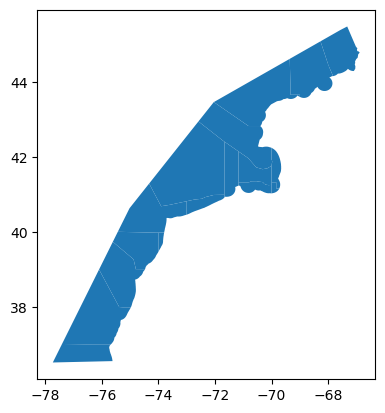

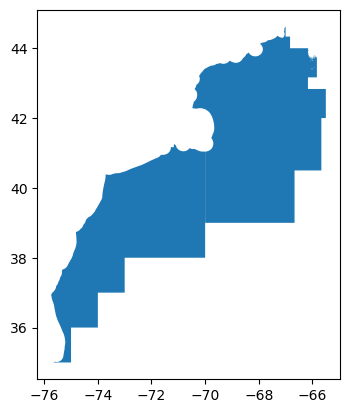

In [4]:
# Load Shapefiles
inshore_zones = gpd.read_file(f"{lobecol_path}12nm_poly_statarea")
offshore_zones = gpd.read_file(f"{lobecol_path}offshore_sne_gom_dissolve/offshore_sne_gom_dissolve.shp")

# Plot inshore
inshore_zones.plot()

# Plot Offshore
offshore_zones.plot()

# Pull Surface and Bottom Out of everything

The following function will take an xarray dataset with some arguments and identify the maximum depth dimension index that holds non-NA values of some variable. These indices can then be used to extract values at those depths, which should correspond with "bottom" values. 


In [5]:
# Identify Bottom Indices
# find bottom temp for any netcdf with depth
def find_deepest_depth_indices(ds, variable_id, y_coord, x_coord, depth_coord, maxDepth = 2000):


    # Subset up to an optional max depth
    kwargs = {depth_coord: slice(0, maxDepth)}
    bottom_400 = ds.sel(**kwargs)

    # First get the vertical True/False of valid values
    idx = bottom_400[variable_id].isel(time=0).isnull()
    idx_vals = idx.values


    if len(bottom_400[variable_id][x_coord].dims) == 2:
        multiIndex = True
    else:
        multiIndex = False

    if multiIndex == True:
        dims0 = bottom_400[y_coord].dims[0]
        dims1 = bottom_400[y_coord].dims[1]
    else:
        dims0 = y_coord
        dims1 = x_coord


    # Create the initial final array to store indices (integer type)
    depth_indices = np.zeros((len(idx[y_coord][dims0]), len(idx[x_coord][dims1]))).astype(int)

    # Now find the deepest depth where values are True and store in indices array
    for i in range(len(bottom_400[dims1].values)):
        for j in range(len(bottom_400[dims0].values)):
            located = np.where(idx_vals[:, j, i] == False)
            try:
                depth_indices[j, i] = int(located[-1][-1])
            except IndexError:
                depth_indices[j, i] = 1

    # Gather as a DataArray
    ind = xr.DataArray(depth_indices, dims=[dims0, dims1])

    return ind


In [6]:
# Load all of the Glorys year as one file

# Load GLORYs
fpaths_glorys_full = []
for file in fpaths_glorys:
    fpaths_glorys_full.append(f"{glorys_path}{file}")

# # Lazy-load the data itself using xr.open_mfdataset
glorys_all = xr.open_mfdataset(fpaths_glorys_full, combine = "by_coords", parallel = True)
glorys_all

<xarray.Dataset> Size: 17GB
Dimensions:    (time: 961, depth: 38, latitude: 132, longitude: 226)
Coordinates:
  * depth      (depth) float32 152B 0.494 1.541 2.646 ... 1.245e+03 1.452e+03
  * latitude   (latitude) float32 528B 35.25 35.33 35.42 ... 46.0 46.08 46.17
  * longitude  (longitude) float32 904B -75.67 -75.58 -75.5 ... -57.0 -56.92
  * time       (time) datetime64[ns] 8kB 1993-01-01 1993-01-02 ... 2023-01-31
Data variables:
    thetao     (time, depth, latitude, longitude) float64 9GB dask.array<chunksize=(31, 38, 132, 226), meta=np.ndarray>
    so         (time, depth, latitude, longitude) float64 9GB dask.array<chunksize=(31, 38, 132, 226), meta=np.ndarray>
Attributes: (12/25)
    Conventions:               CF-1.4
    bulletin_date:             2021-07-07 00:00:00
    bulletin_type:             operational
    comment:                   CMEMS product
    domain_name:               GL12
    easting:                   longitude
    ...                        ...
    references:                http://www.mercator-ocean.fr
    source:                    MERCATOR GLORYS12V1
    title:                     daily mean fields from Global Ocean Physics An...
    z_max:                     5727.9169921875
    z_min:                     0.49402499198913574
    copernicusmarine_version:  1.3.1

### Get Indices for "Bottom" Layer

In [7]:
# Pull the bottom indices from the single glorys file
glorys_bottom_idx = find_deepest_depth_indices(
    ds = glorys_single, 
    variable_id = 'thetao', 
    x_coord = 'longitude', 
    y_coord = 'latitude', 
    depth_coord = 'depth', 
    maxDepth = 1600)

### Pull the Data at the "Bottom" Indices Across Time

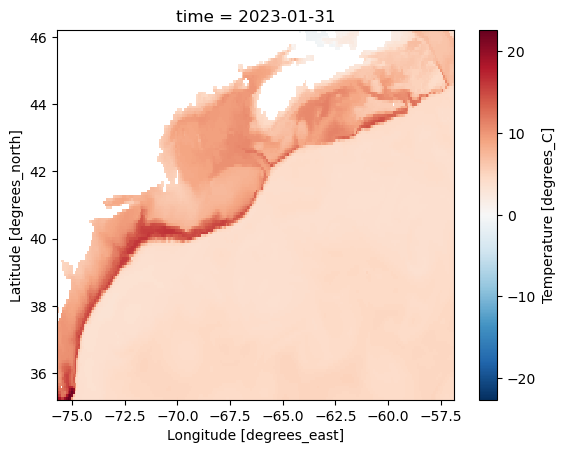

In [8]:
# Use that to extract the variables we care about

# use kwargs to pull values for those indices
kwdepth = {'depth': glorys_bottom_idx}
var_array = glorys_all['thetao']


# Now index the values out
dsSel = var_array.isel(**kwdepth)
ds = dsSel.to_dataset()
ds.thetao.isel(time = -1).plot()

### Mask Values where Depth was* Greater than Max Depth

The Glorys data was downloaded to a max depth of 1500m. So the indices returned in the previous step are returning true bottom layer indices for areas shallower than 1500m, but for areas deeper than this it is returning a "false bottom" of 1500m.

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

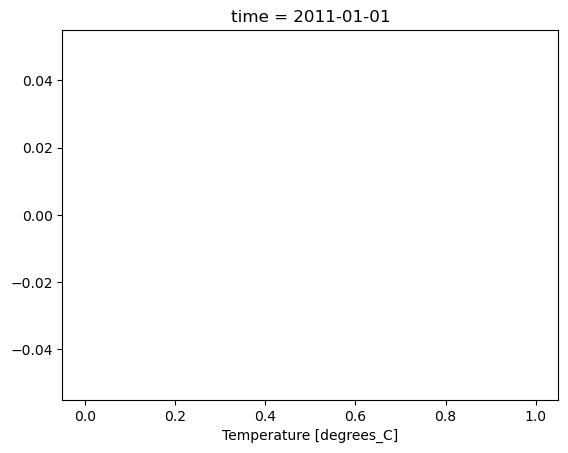

In [24]:
# Get/Make Mask?
masked_depth = glorys_single.thetao.where(glorys_single.depth >= 1500, np.nan)


In [32]:
# Refocus/Reshape
surface_ds = glorys_all.thetao.isel(depth = 0).to_dataset().rename_vars({"thetao" : "surface_temp"})
bottom_ds = ds.rename_vars({"thetao" : "bottom_temp"})
bottom_ds

<xarray.Dataset> Size: 229MB
Dimensions:      (latitude: 132, longitude: 226, time: 961)
Coordinates:
    depth        (latitude, longitude) float32 119kB 7.93 7.93 ... 55.76 55.76
  * latitude     (latitude) float32 528B 35.25 35.33 35.42 ... 46.0 46.08 46.17
  * longitude    (longitude) float32 904B -75.67 -75.58 -75.5 ... -57.0 -56.92
  * time         (time) datetime64[ns] 8kB 1993-01-01 1993-01-02 ... 2023-01-31
Data variables:
    bottom_temp  (time, latitude, longitude) float64 229MB dask.array<chunksize=(31, 132, 226), meta=np.ndarray>

In [ ]:
# Crop to a region

# Convert to timeseries